<p style="font-size:32px"> 
    <b>Personalized cancer diagnosis</b> 
</p>

## Description

## Data

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
        
<p> :: Memorial Sloan Kettering Cancer Center (MSKCC) :: </p>

There are nine different classes a genetic mutation can be classified on.

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

Therefore the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text

> <b> Some of the test data is machine-generated to prevent hand labeling.</b>


- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

## Real-world/Business objectives and constraints

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
# import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from pathlib import Path

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [3]:
path = Path('../data/cancer_diagnosis')
list(path.iterdir())

[PosixPath('../data/cancer_diagnosis/msk-redefining-cancer-treatment.zip'),
 PosixPath('../data/cancer_diagnosis/stage1_solution_filtered.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_sample_submission.csv'),
 PosixPath('../data/cancer_diagnosis/stage2_sample_submission.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_test_text.csv'),
 PosixPath('../data/cancer_diagnosis/stage2_test_text.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_test_variants.csv'),
 PosixPath('../data/cancer_diagnosis/stage2_test_variants.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage_2_private_solution.csv.7z'),
 PosixPath('../data/cancer_diagnosis/test_sub_0.csv'),
 PosixPath('../data/cancer_diagnosis/test_text'),
 PosixPath('../data/cancer_diagnosis/test_text.zip'),
 PosixPath('../data/cancer_diagnosis/test_variants'),
 PosixPath('../data/cancer_diagnosis/test_variants.zip'),
 PosixPath('../data/cancer_diagnosis/training_text'),
 PosixPath('../data/cancer_diagnosis/training_text.zip')

In [4]:
df_variants = pd.read_csv(path/'training_variants')
print(f"Number of data points and features:: {df_variants.shape}")
df_variants.head()

Number of data points and features:: (3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>
</p>

In [5]:
df_variants_test = pd.read_csv(path/'stage2_test_variants.csv')
print(f"Number of data points and features:: {df_variants_test.shape}")
df_variants_test.head()

Number of data points and features:: (986, 3)


,ID,Gene,Variation
0,1,CHEK2,H371Y
1,2,AXIN2,Truncating Mutations
2,3,WNT4,E216G
3,4,SUCLA2,G118R
4,5,BRAF,T599insTT


In [6]:
df_text = pd.read_csv(path/'training_text', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=1)
print(f"Number of data points and features:: {df_text.shape}")
df_text.head()


Number of data points and features:: (3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
df_text_test = pd.read_csv(path/'stage2_test_text.csv', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=1)
print(f"Number of data points and features:: {df_text_test.shape}")
df_text_test.head()


Number of data points and features:: (986, 2)


,ID,TEXT
0,1,The incidence of breast cancer is increasing i...
1,2,An unselected series of 310 colorectal carcino...
2,3,Mycosis fungoides and Sézary syndrome are prim...
3,4,Regulated progression through the cell cycle ...
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...


In [8]:
test_sub_0 = pd.DataFrame(df_text_test.ID)
for i in range(1, 10):
    test_sub_0[f'class{i}'] = 0
test_sub_0.to_csv(path/'test_sub_0.csv', index=False)

In [9]:
df_sub = pd.read_csv(path/'test_sub_0.csv')
df_sub.shape

(986, 10)

In [10]:
df_sub = pd.read_csv(path/'stage2_sample_submission.csv')
df_sub.shape

(986, 10)

In [11]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def text_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+', ' ', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
            if word not in stop_words:
                string += word + " "
        df_text[column][index] = string

In [12]:
# #text processing stage.
# start_time = time.clock()
# for index, row in df_final.iterrows():
#     if type(row['TEXT']) is str:
#         text_preprocessing(row['TEXT'], index, 'TEXT')
#     else:
#         print(f'There is no test for row:: {index}')
# print(f"Time took for preprocessing the text:: {time.clock() - start_time}")

In [13]:
# #text processing stage.
# start_time = time.clock()
# for index, row in df_final_test.iterrows():
#     if type(row['TEXT']) is str:
#         text_preprocessing(row['TEXT'], index, 'TEXT')
#     else:
#         print(f'There is no test for row:: {index}')
# print(f"Time took for preprocessing the text:: {time.clock() - start_time}")

In [14]:
df_final = pd.merge(df_variants, df_text, on='ID', how='left')
print(f"Number of data points and features:: {df_final.shape}")
df_final.head()

Number of data points and features:: (3321, 5)


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [15]:
df_final_test = pd.merge(df_variants_test, df_text_test, on='ID', how='left')
print(f"Number of data points and features:: {df_final_test.shape}")
df_final_test.head()


Number of data points and features:: (986, 4)


,ID,Gene,Variation,TEXT
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...


## Some basic statistical test

In [16]:
df_final.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,3321,NaN,NaN,NaN,1660,958.834,0,830,1660,2490,3320
Gene,3321,264,BRCA1,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Variation,3321,2996,Truncating Mutations,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,3321,NaN,NaN,NaN,4.36585,2.30978,1,2,4,7,9
TEXT,3316,1920,The PTEN (phosphatase and tensin homolog) phos...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_final_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,986,NaN,NaN,NaN,493.5,284.778,1,247.25,493.5,739.75,986
Gene,986,279,TP53,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Variation,986,945,Truncating Mutations,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TEXT,986,874,Among the best-studied therapeutic targets in ...,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


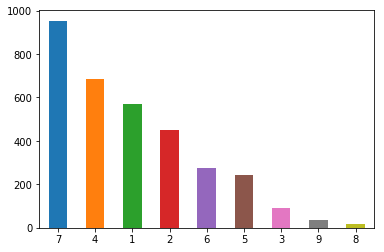

In [18]:
df_final.Class.value_counts().plot(kind='bar', rot=0);

In [19]:
df_final[df_final.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [20]:
# df_final.loc[df_final['TEXT'].isnull(), 'TEXT'] = df_final.Gene + ' ' + df_final.Variation

In [21]:
# df_final[df_final.ID == 2755]

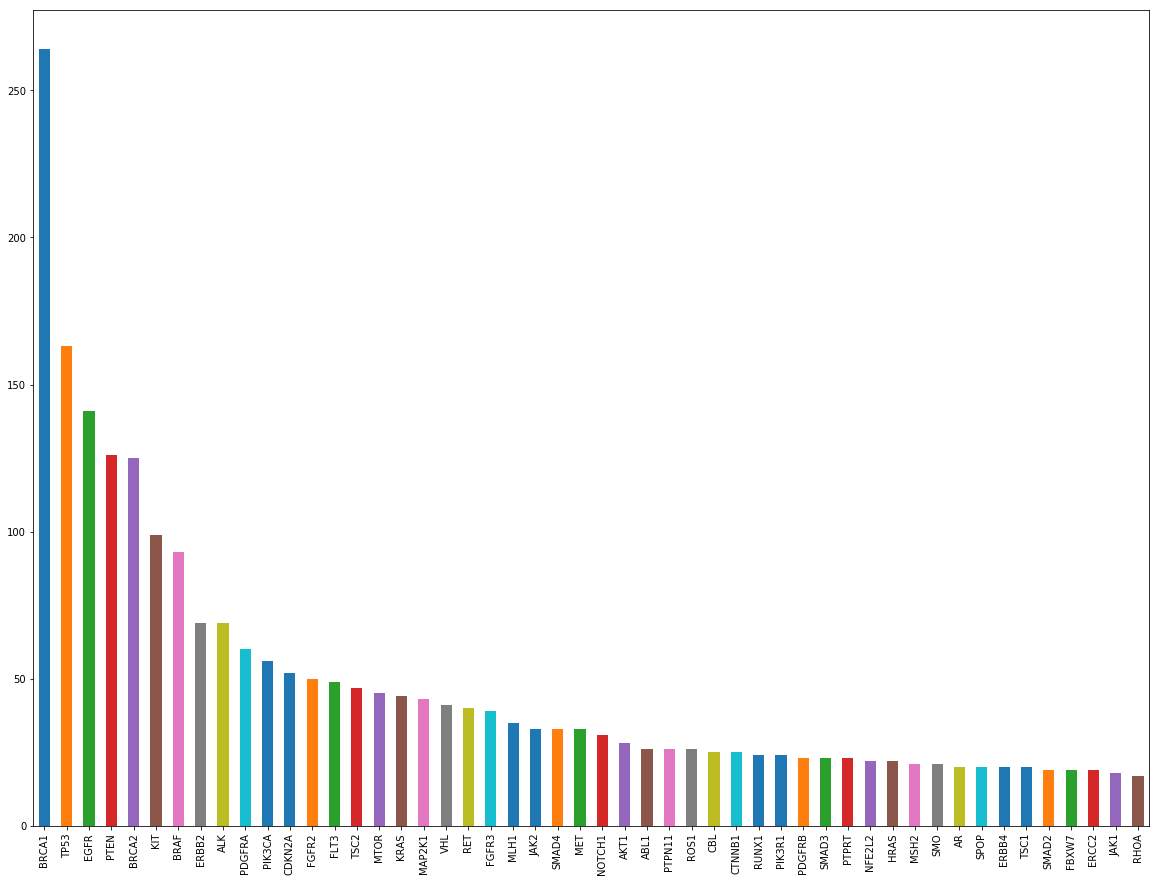

In [25]:
df_final.Gene.value_counts()[:50].plot(kind='bar', rot=90, figsize=(20,15));

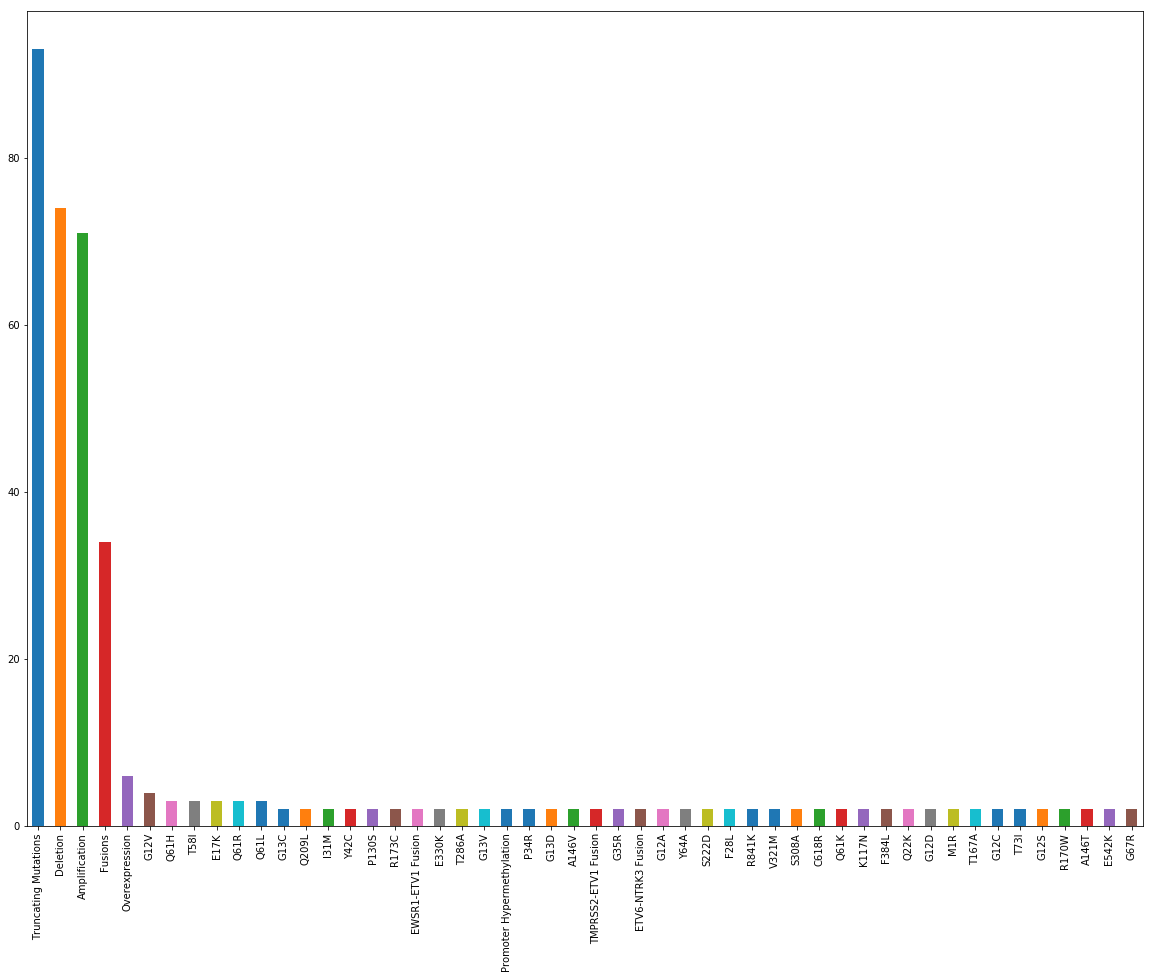

In [26]:
df_final.Variation.value_counts()[:50].plot(kind='bar', rot=90, figsize=(20,15));



In [34]:
def textlen(train):
    k = train['TEXT'].apply(lambda x: len(str(x).split()))
    l = train['TEXT'].apply(lambda x: len(str(x)))
    return k, l

df_final['Text_word_count'], df_final['Text_char_count'] = textlen(df_final)
df_final_test['Text_word_count'], df_final_test['Text_char_count'] = textlen(df_final_test)



In [57]:
df_final['Gene_Variation'] = df_final.Gene + '_' + df_final.Variation
df_final['Variation_Gene'] = df_final.Variation + '_' + df_final.Gene

df_final_test['Gene_Variation'] = df_final_test.Gene + '_' + df_final_test.Variation
df_final_test['Variation_Gene'] = df_final_test.Variation + '_' + df_final_test.Gene


In [58]:
df_final.head()

,ID,Gene,Variation,Class,TEXT,Text_word_count,Text_char_count,Gene_Variation,Variation_Gene
0,0,FAM58A,Truncating_Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089,39672,FAM58A_Truncating_Mutations,Truncating_Mutations_FAM58A
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5756,36691,CBL_W802*,W802*_CBL
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5756,36691,CBL_Q249E,Q249E_CBL
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572,36238,CBL_N454D,N454D_CBL
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202,41308,CBL_L399V,L399V_CBL


In [86]:
df_final.loc[df_final['TEXT'].isnull(), ['Text_word_count', 'Text_char_count']] = 0
df_final.loc[df_final['TEXT'].isnull(), 'TEXT'] = '<UNK>'


In [89]:
df_final[df_final['TEXT'] == '<UNK>']

,ID,Gene,Variation,Class,TEXT,Text_word_count,Text_char_count,Gene_Variation,Variation_Gene
1109,1109,FANCA,S1088F,1,<UNK>,0,0,FANCA_S1088F,S1088F_FANCA
1277,1277,ARID5B,Truncating_Mutations,1,<UNK>,0,0,ARID5B_Truncating_Mutations,Truncating_Mutations_ARID5B
1407,1407,FGFR3,K508M,6,<UNK>,0,0,FGFR3_K508M,K508M_FGFR3
1639,1639,FLT1,Amplification,6,<UNK>,0,0,FLT1_Amplification,Amplification_FLT1
2755,2755,BRAF,G596C,7,<UNK>,0,0,BRAF_G596C,G596C_BRAF


In [94]:
y = df_final['Class'].values
df_final.Gene = df_final.Gene.str.replace('\s+', '_')
df_final.Variation = df_final.Variation.str.replace('\s+', '_')


X_train, X_test, y_train, y_test = train_test_split(df_final, y, stratify=y, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


(2124, 9) (2124,)
(532, 9) (532,)
(665, 9) (665,)


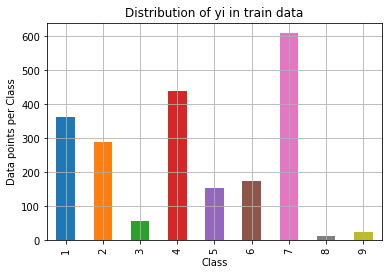

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


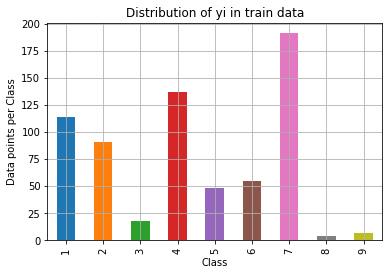

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


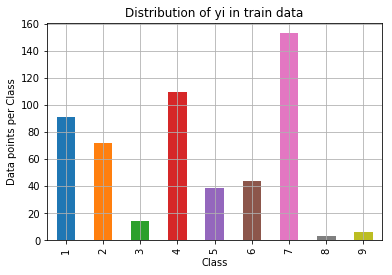

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [95]:
train_class_distribution = X_train['Class'].value_counts().sortlevel()
test_class_distribution = X_test['Class'].value_counts().sortlevel()
cv_class_distribution = X_cv['Class'].value_counts().sortlevel()


my_colors = 'rgbkymc'

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/X_train.shape[0]*100), 3), '%)')
print("=" * 100)


test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/X_test.shape[0]*100), 3), '%)')
print("=" * 100)

cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/X_cv.shape[0]*100), 3), '%)')
print("=" * 100)

In [96]:
X_train.head()

,ID,Gene,Variation,Class,TEXT,Text_word_count,Text_char_count,Gene_Variation,Variation_Gene
1537,1537,ALK,I1250T,5,"In the era of personalized medicine, understan...",6768,46134,ALK_I1250T,I1250T_ALK
2340,2340,JAK2,R683S,7,Children with Down's syndrome have a greatly i...,14620,94365,JAK2_R683S,R683S_JAK2
2366,2366,STK11,F354L,5,Abstract Germline mutations of the LKB1 gene ...,6588,44676,STK11_F354L,F354L_STK11
1546,1546,ALK,KIF5B-ALK_Fusion,7,We report the preclinical evaluation of PF-064...,9742,65412,ALK_KIF5B-ALK_Fusion,KIF5B-ALK_Fusion_ALK
1624,1624,VHL,L158V,4,"In von Hippel-Lindau (VHL) disease, germline m...",7995,52114,VHL_L158V,L158V_VHL


### Helper Functions

In [97]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = X_train[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = X_train[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea
            

In [98]:
# one-hot encoding of Gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])

train_gene_feature_onehotCoding.shape

(2124, 226)

In [99]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_train))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_test))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_cv))

train_gene_feature_responseCoding.shape

(2124, 9)

In [100]:
variation_vectorizer = CountVectorizer()

train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train.Variation)
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test.Variation)
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv.Variation)

train_variation_feature_onehotCoding.shape, test_variation_feature_onehotCoding.shape, cv_variation_feature_onehotCoding.shape


((2124, 1964), (665, 1964), (532, 1964))

In [101]:
alpha = 1

train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', X_train))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', X_test))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', X_cv))

train_variation_feature_responseCoding.shape, test_variation_feature_responseCoding.shape, cv_variation_feature_responseCoding.shape



((2124, 9), (665, 9), (532, 9))

### Encode categorical feature Gene_Variation combination

In [102]:
variation_vectorizer = CountVectorizer()

train_gene_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train.Gene_Variation)
test_gene_variation_feature_onehotCoding = variation_vectorizer.transform(X_test.Gene_Variation)
cv_gene_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv.Gene_Variation)

train_gene_variation_feature_onehotCoding.shape, test_gene_variation_feature_onehotCoding.shape, cv_gene_variation_feature_onehotCoding.shape


((2124, 2164), (665, 2164), (532, 2164))

In [103]:
alpha = 1

train_gene_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Gene_Variation', X_train))
test_gene_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Gene_Variation', X_test))
cv_gene_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Gene_Variation', X_cv))

train_gene_variation_feature_responseCoding.shape, test_gene_variation_feature_responseCoding.shape, cv_gene_variation_feature_responseCoding.shape



((2124, 9), (665, 9), (532, 9))

### Encode categorical feature Variation_Gene combination

In [104]:
variation_vectorizer = CountVectorizer()

train_variation_gene_feature_onehotCoding = variation_vectorizer.fit_transform(X_train.Variation_Gene)
test_variation_gene_feature_onehotCoding = variation_vectorizer.transform(X_test.Variation_Gene)
cv_variation_gene_feature_onehotCoding = variation_vectorizer.transform(X_cv.Variation_Gene)

train_variation_gene_feature_onehotCoding.shape, test_variation_gene_feature_onehotCoding.shape, cv_variation_gene_feature_onehotCoding.shape


((2124, 2185), (665, 2185), (532, 2185))

In [105]:
alpha = 1

train_variation_gene_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation_Gene', X_train))
test_variation_gene_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation_Gene', X_test))
cv_variation_gene_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation_Gene', X_cv))

train_variation_gene_feature_responseCoding.shape, test_variation_gene_feature_responseCoding.shape, cv_variation_gene_feature_responseCoding.shape



((2124, 9), (665, 9), (532, 9))

### Encoding Text Feature

In [107]:
import math 

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [112]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    return dictionary


dict_list = []
for i in range(1, 10):
    cls_text = X_train[X_train.Class == i]
    dict_list.append(extract_dictionary_paddle(cls_text))
    
total_dict = extract_dictionary_paddle(X_train)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [108]:
text_vectorizer = CountVectorizer(min_df=3, stop_words='english', ngram_range=(1, 3), max_features=10000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print(f"Total number of unique words in train data :: {len(train_text_features)}")


Total number of unique words in train data :: 10000


In [113]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_cv)

In [114]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [115]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [116]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

### Neumerical Feature

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>